In [1]:
import logging, uuid, time, csv, os

from kubernetes import client, config, watch

logging.basicConfig(level=logging.INFO)
config.load_kube_config("/home/goughes/k8s/configs/erikdev-admin.yaml")
core_api = client.CoreV1Api()
batch_api = client.BatchV1Api()
apps_api = client.AppsV1Api()
# create results directory structure
os.makedirs("results", exist_ok=True)
experiments = ["E1", "E2", "E3", "E4", "E5"]
for e in experiments:
    os.makedirs("results/" + e, exist_ok=True)

## Kubernetes API class

In [2]:
# based on https://medium.com/@aris.david/how-to-create-a-job-using-kubernetes-python-client-ed00ac2b791d
class Kubernetes:
    def __init__(self):

        # Init Kubernetes
        self.core_api = client.CoreV1Api()
        self.batch_api = client.BatchV1Api()

    def get_all_namespaces(self):
        namespaces = self.core_api.list_namespace()
        all_namespaces = []
        for ns in namespaces.items:
            all_namespaces.append(ns.metadata.name)
        return all_namespaces
            
    def create_namespace(self, namespace):

        all_namespaces = self.get_all_namespaces()

        if namespace in all_namespaces:
            logging.info(f"Namespace {namespace} already exists. Reusing.")
        else:
            namespace_metadata = client.V1ObjectMeta(name=namespace)
            self.core_api.create_namespace(
                client.V1Namespace(metadata=namespace_metadata)
            )
            logging.info(f"Created namespace {namespace}.")

        return namespace
    
    def delete_namespace(self, namespace):
        all_namespaces = self.get_all_namespaces()
        
        if namespace not in all_namespaces:
            logging.info(f"Namespace {namespace} does not exist.")
        else:
            self.core_api.delete_namespace(name=namespace)
            logging.info(f"Deleted namespace {namespace}.")

    @staticmethod
    def create_container(image, name, pull_policy, cpu_limit, mem_limit, sleep_time):

        resources = client.V1ResourceRequirements(
            requests={"cpu": cpu_limit, "memory": mem_limit},
            limits={"cpu": cpu_limit, "memory": mem_limit}
        )
            
        container = client.V1Container(
            image=image,
            name=name,
            resources=resources,
            image_pull_policy=pull_policy,
            args=[sleep_time],
            command=["sleep"],
        )

        logging.info(
            f"Created sleep container with name: {container.name}, "
            f"image: {container.image} and args: {container.args}"
        )

        return container

    @staticmethod
    def create_pod_template(namespace, pod_name, container, scheduler_name):
        labels={"pod_name": pod_name}
        # add queue and appid labels required for yunikorn 
        if scheduler_name == "yunikorn":
            labels["applicationId"] = pod_name.split("-")[-1]
            labels["queue"] = "root.tenants." + namespace
        if namespace == "backfill":
            pod_template = client.V1PodTemplateSpec(
                spec=client.V1PodSpec(restart_policy="Never", containers=[container], scheduler_name=scheduler_name, priority_class_name="backfill"),
                metadata=client.V1ObjectMeta(name=pod_name, labels=labels),
            )
        else:
            pod_template = client.V1PodTemplateSpec(
                spec=client.V1PodSpec(restart_policy="Never", containers=[container], scheduler_name=scheduler_name),
                metadata=client.V1ObjectMeta(name=pod_name, labels=labels),
            )

        return pod_template

    @staticmethod
    def create_job(job_name, pod_template):
        metadata = client.V1ObjectMeta(name=job_name, labels={"job_name": job_name})

        job = client.V1Job(
            api_version="batch/v1",
            kind="Job",
            metadata=metadata,
            #spec=client.V1JobSpec(backoff_limit=6, template=pod_template),
            spec=client.V1JobSpec(template=pod_template),
        )

        return job
    
    @staticmethod
    def get_all_pods(namespace):
        pods = core_api.list_namespaced_pod(namespace, pretty=True, timeout_seconds=60)
        print("number of pods: " + str(len(pods.items)))
        return pods
    
    @staticmethod
    def get_all_jobs(namespace):
        jobs = batch_api.list_namespaced_job(namespace, pretty=True, timeout_seconds=60)
        print("number of jobs: " + str(len(jobs.items)))
        return jobs
    
    @staticmethod
    def delete_all_jobs(namespace):
        jobs = batch_api.list_namespaced_job(namespace, pretty=True, timeout_seconds=60)
        deleteoptions = client.V1DeleteOptions()
        for job in jobs.items:
            print("Deleting job " + job.metadata.name)
            jobname = job.metadata.name
            api_response = batch_api.delete_namespaced_job(jobname,
                                                           namespace,
                                                           grace_period_seconds=0, 
                                                           propagation_policy='Background')
            logging.debug(api_response)
    
    """
        interval: time to wait/sleep between each job submission
    """
    @staticmethod
    def submit_burst(namespace, scheduler_name, cpu_limit, mem_limit, total_jobs, sleep_time):
        try:
            image = "busybox:1.36"
            container_name = "burst-sleep-" + namespace
            pull_policy = "Never"
            print("bursting", total_jobs, "sleep", sleep_time)
            burst_submitted = 0
            while burst_submitted < total_jobs:
                container = k8s.create_container(image, container_name, pull_policy, cpu_limit, mem_limit, sleep_time)

                pod_id = uuid.uuid4()
                job_id = pod_id
                # create template
                _pod_name = f"{namespace}-burst-pod-{pod_id}"
                if namespace == "backfill":
                        _pod_name = "tenant-" + _pod_name
                _pod_spec = k8s.create_pod_template(namespace, _pod_name, container, scheduler_name)

                # create job
                _job_name = f"{namespace}-burst-{job_id}"
                if namespace == "backfill":
                        _job_name = "tenant-" + _job_name
                _job = k8s.create_job(_job_name, _pod_spec)

                # execute job
                batch_api = client.BatchV1Api()
                batch_api.create_namespaced_job(namespace, _job)
                burst_submitted = burst_submitted + 1
                print("burst jobs", burst_submitted)
        except Exception as e:
            print(e)
            
    @staticmethod
    def submit_workflow(namespace, scheduler_name, cpu_limit, mem_limit, total_jobs, sleep_time, bursts, interval, experiment):
        try:
            image = "busybox:1.36"
            container_name = "sleep-" + namespace
            pull_policy = "Never"
            execution_time = 0
            jobs_submitted = 0
            # some logic to delay the start of tenant3 jobs
            if namespace == "tenant3":
                time.sleep(60)
                execution_time = 60
                if experiment == "E5":
                    time.sleep(30)
                    execution_time += 30
            while jobs_submitted < total_jobs:
                for burst in bursts:
                    if execution_time == burst[0]:
                        burst_cpu_limit = burst[1]
                        burst_mem_limit = burst[2]
                        burst_total_jobs = burst[3]
                        burst_sleep_time = burst[4]
                        print("Submitting burst at " + str(execution_time))
                        k8s.submit_burst(namespace, scheduler_name, burst_cpu_limit, burst_mem_limit, burst_total_jobs, burst_sleep_time)

                if int(cpu_limit) > 0:
                    container = k8s.create_container(image, container_name, pull_policy, cpu_limit, mem_limit, sleep_time)

                    pod_id = uuid.uuid4()
                    job_id = pod_id
                    # create template
                    _pod_name = f"{namespace}-pod-{pod_id}"
                    if namespace == "backfill":
                        _pod_name = "tenant-" + _pod_name
                    _pod_spec = k8s.create_pod_template(namespace, _pod_name, container, scheduler_name)

                    # create job
                    _job_name = f"{namespace}-{job_id}"
                    if namespace == "backfill":
                        _job_name = "tenant-" + _job_name
                    _job = k8s.create_job(_job_name, _pod_spec)

                    # execute job
                    batch_api = client.BatchV1Api()
                    batch_api.create_namespaced_job(namespace, _job)
                jobs_submitted = jobs_submitted + 1
                execution_time = execution_time + interval
                time.sleep(interval)
        except Exception as e:
            print(e)

## Experiment class

In [3]:
from multiprocess import Pool
import pandas as pd
import pprint
import csv
import time


class Experiment():
    def __init__(self, experiment_name, experiment_number, namespaces, scheduler_name, params):
        self.experiment_name = experiment_name
        self.experiment_number = experiment_number
        self.namespaces = namespaces
        self.scheduler_name = scheduler_name
        self.params = params
        self.exp_data = {}
        self.k8s = Kubernetes()
    
    def calculate_total_completed(self):
        total = 0
        for param in self.params:
            cores = int(param[1])
            num_jobs = param[3]
            tenant_total = cores * num_jobs
            bursts = param[5]
            burst_total = 0
            for burst in bursts:
                burst_cores = int(burst[1])
                burst_num_jobs = burst[3]
                burst_total = burst_total + (burst_cores * burst_num_jobs)
            total += tenant_total
            total += burst_total
        return total

    def submit_parallel_workflows(self, params):
        try:
            namespace  = params[0]
            cpu_limit  = params[1]
            mem_limit  = params[2]
            num_jobs   = params[3]
            sleep_time = params[4]
            bursts     = params[5]
            interval   = params[6]
            experiment = params[7]
            self.k8s.submit_workflow(namespace, self.scheduler_name, cpu_limit, mem_limit, num_jobs, sleep_time, bursts, interval, experiment)
        except Exception as e:
            print(e)
    
    def start(self):
        # yunikorn needs a restart due to some bug?
        if self.scheduler_name == "yunikorn":
            api_response = apps_api.patch_namespaced_deployment_scale("yunikorn-scheduler", "yunikorn", {"spec": {"replicas": 0}})
            api_response = apps_api.patch_namespaced_deployment_scale("yunikorn-scheduler", "yunikorn", {"spec": {"replicas": 1}})
            time.sleep(2)
        try:
            # submit multithreaded workflows, one for each tenant
            p = Pool(len(self.params))
            result = p.map_async(self.submit_parallel_workflows, self.params)
            return result
        except Exception as e:
            print(e)
    
    def cleanup_all_namespaces(self):
        namespaces = ["tenant1", "tenant2", "tenant3", "tenant4", "backfill"]

        # clean each namespace of any leftover jobs
        for namespace in namespaces:
            #k8s.create_namespace(namespace)
            self.k8s.delete_all_jobs(namespace)
            #k8s.delete_namespace(namespace)

        # wait until all the pods are deleted before starting run
        cleaned_up = False
        while not cleaned_up:
            print("waiting for pod clean up...")
            all_pods = core_api.list_pod_for_all_namespaces()
            all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
            if not all_tenant_pods:
                print("pods are cleaned up!")
                cleaned_up = True
            time.sleep(1)

                # returns total pending/running/completed cores across all namespaces
    def get_totals(self, namespaces):
        total_running = 0
        total_pending = 0
        total_completed = 0
        total_preempted = 0
        for namespace in namespaces:
            if not self.exp_data[namespace+'_pending'] or not self.exp_data[namespace+'_running'] or not self.exp_data[namespace+'_completed'] or not self.exp_data[namespace+'_preempted']:
                return 0, 0, 0, 0
            total_pending += self.exp_data[namespace+'_pending'][-1] 
            total_running += self.exp_data[namespace+'_running'][-1]
            total_completed += self.exp_data[namespace+'_completed'][-1]
            total_preempted += self.exp_data[namespace+'_preempted'][-1]

        return total_pending, total_running, total_completed, total_preempted

    def monitor(self):
        try:
            completed_target = self.calculate_total_completed()
            # initialize data dictionary
            self.exp_data['timestamp'] = [] # empty array for timestamps

            for namespace in self.namespaces:
                self.exp_data[namespace+'_pending'] = [] # empty array for each namespace's pending jobs
                self.exp_data[namespace+'_running'] = [] # empty array for each namespace's running jobs
                self.exp_data[namespace+'_completed'] = [] # empty array for each namespace's completed jobs
                self.exp_data[namespace+'_preempted'] = [] # empty array for each namespace's preempted jobs

            finished = False
            timestamp = round(time.time())
            while not finished:
                #if timestamp == 60:
                    #finished = True
                # get pods from all namespaces
                all_pods = core_api.list_pod_for_all_namespaces()
                # get jobs from all namespaces
                all_jobs = batch_api.list_job_for_all_namespaces()

                # filter for pods with "tenant" in the name
                all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
                all_tenant_jobs = [ job for job in all_jobs.items if "tenant" in job.metadata.name]

                # insert the timestamp
                #exp_data['timestamp'].append(int(time.time())) # epoch time
                _time = round(time.time()) - timestamp
                self.exp_data['timestamp'].append(_time)

                # iterate through namespaces and collect info on pending/running/completed jobs
                for namespace in self.namespaces:
                    # get pods for the tenant of current namespace
                    tenant_pods = [ pod for pod in all_tenant_pods if namespace in pod.metadata.name]
                    tenant_jobs = [ job for job in all_tenant_jobs if namespace in job.metadata.name]

                    running_cores = 0
                    pending_cores = 0
                    completed_cores = 0
                    preempted_cores = 0

                    # loop through pods 
                    for pod in tenant_pods:
                        cores = int(pod.spec.containers[0].resources.limits['cpu'])
                        if pod.status.phase == "Pending":
                            pending_cores = pending_cores + cores
                        elif pod.status.phase == "Running":
                            running_cores = running_cores + cores
                        elif pod.status.phase == "Succeeded":
                            completed_cores = completed_cores + cores

                    # check for pending jobs - jobs that are unable to submit a pod due to quota limits
                    for job in tenant_jobs:
                        has_pod = False
                        job_name = job.metadata.name
                        for pod in tenant_pods:
                            if job_name in pod.metadata.name:
                                has_pod = True
                        job_cores = int(job.spec.template.spec.containers[0].resources.limits['cpu'])
                        if not has_pod and job.status.active is None and job.status.terminating is None and job.status.succeeded is None and job.status.completion_time is None and job.status.ready == 0 and job.status.conditions is None :
                            pending_cores = pending_cores + job_cores
                        if job.status.failed is not None:
                            preempted_cores += job_cores

                    self.exp_data[namespace+'_pending'].append(pending_cores)
                    self.exp_data[namespace+'_running'].append(running_cores)
                    self.exp_data[namespace+'_completed'].append(completed_cores)
                    self.exp_data[namespace+'_preempted'].append(preempted_cores)


                # check to see if there are still any running or pending jobs
                total_pending, total_running, total_completed, total_preempted = self.get_totals(self.namespaces)
                print("time", round(time.time()), "timestamp", _time, "pending", total_pending, "running", total_running, "completed", total_completed, "preempted", total_preempted)
                #if total_pending == 0 and total_running == 0 and total_completed > 0:
                if total_completed >= completed_target:
                    finished = True
                #timestamp += 1
                time.sleep(1)
            print("all done!")
            return self.exp_data
        except Exception as e:
            print(e)
            
    def graph(self):

        results_location = "results" + os.path.sep + self.experiment_name.split("-")[0] + os.path.sep + self.experiment_name + "-" + self.scheduler_name + "-run" + self.experiment_number
        exp_full_dataframe = pd.DataFrame(self.exp_data)
        exp_full_dataframe.to_csv(results_location + "-rawdata.csv", index=False)

        exp_data_copy = self.exp_data.copy()
        # for graph, remove completed pods
        for namespace in self.namespaces:
            self.exp_data.pop(namespace+'_completed')

        exp_dataframe = pd.DataFrame(self.exp_data)

        color = ["blue", "blue", "blue", "green", "green", "green", "red", "red", "red", "orange", "orange", "orange"]
        style = ["--",   "-",    ".-",   "--",    "-",     ".-",    "--",  "-",   ".-",  "--",     "-",      ".-"]

        plot = exp_dataframe.plot(x="timestamp", figsize=(20,10), color=color, style=style, fontsize="14", lw=2)
        plot.set_xlabel("Run time (seconds)", fontsize=16)
        plot.set_ylabel("Number of Cores", fontsize=16)
        #plot.legend(fontsize=14, bbox_to_anchor=(1.19, 0.6), loc="center right")
        plot.legend(fontsize=14)

        figure = plot.figure
        #figure.tight_layout()
        figure.savefig(results_location + "-graph-preemption.png")

        # for graph, remove completed pods
        for namespace in self.namespaces:
            self.exp_data.pop(namespace+'_preempted')

        exp_dataframe = pd.DataFrame(self.exp_data)

        color = ["blue", "blue", "green", "green", "red", "red", "orange", "orange"]
        style = ["--",   "-",    "--",    "-",     "--",  "-",   "--",     "-"]

        plot = exp_dataframe.plot(x="timestamp", figsize=(20,10), color=color, style=style, fontsize="14", lw=2)
        plot.set_xlabel("Run time (seconds)", fontsize=16)
        plot.set_ylabel("Number of Cores", fontsize=16)
        plot.legend(fontsize=14)
        #plot.legend(fontsize=14, bbox_to_anchor=(1.19, 0.6), loc="center right")

        figure = plot.figure
        figure.savefig(results_location + "-graph.png")
        
    def save_results(self):
        all_pods = core_api.list_pod_for_all_namespaces()
        all_jobs = batch_api.list_job_for_all_namespaces()
        # filter for pods with "tenant" in the name
        all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
        all_tenant_jobs = [ job for job in all_jobs.items if "tenant" in job.metadata.name]   

        # set up output csv for dependent variables
        results_location = "results" + os.path.sep + self.experiment_name.split("-")[0] + os.path.sep + self.experiment_name + "-" + self.scheduler_name + "-run" + self.experiment_number
        output_csv = results_location + "-depvars.csv"
        output_fields = ["experiment", "run", "tenant", "total cores", "total queue time", "avg queue time", "total job run time", "total queue + job run time", "workflow run time (makespan)"]
        output_rows = []

        for namespace in self.namespaces:
            tenant_pods = [ pod for pod in all_tenant_pods if namespace in pod.metadata.name]
            tenant_jobs = [ job for job in all_tenant_jobs if namespace in job.metadata.name]

            total_cores = 0
            total_queue_time = 0
            total_run_time = 0
            total_time = 0

            # start/end used to calculate makespan
            start = None
            end = None
            makespan = 0
            for pod in tenant_pods:
                cores = int(pod.spec.containers[0].resources.limits['cpu'])
                total_cores += cores
                pod_schedule_time = pod.metadata.creation_timestamp
                if namespace == "backfill":
                    job_name = pod.metadata.name[:-5]
                else:
                    job_name = pod.metadata.name[:-6]
                for job in tenant_jobs:
                    if job.metadata.name == job_name:
                        schedule_time = job.metadata.creation_timestamp
                #pod_start_time = pod.status.start_time
                pod_start_time = pod.status.container_statuses[0].state.terminated.started_at
                pod_end_time = pod.status.container_statuses[0].state.terminated.finished_at
                pod_queue_time = pod_start_time - schedule_time
                pod_run_time = pod_end_time - pod_start_time
                pod_total_time = pod_end_time - schedule_time
                total_queue_time = total_queue_time + int(pod_queue_time.total_seconds())
                total_run_time = total_run_time + int(pod_run_time.total_seconds())
                total_time = total_time + int(pod_total_time.total_seconds())
                # calculate makespan
                if not start or schedule_time < start:
                    start = schedule_time
                if not end or pod_end_time > end:
                    end = pod_end_time
            average_queue_time = round(total_queue_time / len(tenant_pods))
            print(namespace, "Total queue time:", total_queue_time)
            print(namespace, "Average queue time:", average_queue_time)
            print(namespace, "Total run time for all jobs:", total_run_time)
            print(namespace, "Total queue + run time for all jobs:", total_time)
            makespan = round((end - start).total_seconds())
            print(namespace, "Total workflow run time (makespan):", makespan)
            output_rows.append([self.experiment_name, self.experiment_number, namespace, total_cores, total_queue_time, average_queue_time, total_run_time, total_time, makespan])

        with open(output_csv, 'w') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(output_fields)
            csvwriter.writerows(output_rows)
        
        

In [4]:
k8s = Kubernetes()

In [5]:
def run_experiment(experiment_name, namespaces, params, schedulers):
    for scheduler in schedulers:
        for experiment_number in range(1,6):
            exp = Experiment(experiment_name, str(experiment_number), namespaces, scheduler, params)
            completed_target = exp.calculate_total_completed()
            logging.info("Starting experiment " + experiment_name + " run " + str(experiment_number) + " with " + str(completed_target) + " total cores requested using " + scheduler)
            exp.cleanup_all_namespaces()
            exp.start()
            exp.monitor()
            exp.graph()
            exp.save_results()

## Default Scheduler - Experiment 1

## Default Scheduler Experiment 2

INFO:root:Starting experiment E5 run 1 with 1650 total cores requested using default-scheduler


Deleting job tenant1-burst-017d5c3d-39b4-4b63-95dd-17ffeaedddec
Deleting job tenant1-burst-0205d1ce-8f23-483a-b66e-31cbc862db9a
Deleting job tenant1-burst-026ee9fb-ed63-4763-935e-1e9c6262860f
Deleting job tenant1-burst-05669348-7c80-45ee-a8d6-74d3e0dd4625
Deleting job tenant1-burst-08405e0c-c87b-4bad-b436-bbd9bec81a67
Deleting job tenant1-burst-0a7f8391-1ecc-4bb6-b919-1d71db81935d
Deleting job tenant1-burst-0db67c9d-2fa1-48eb-a8a8-84740ed406b7
Deleting job tenant1-burst-0e8f9d83-f1ce-4290-b07c-7ef861f0018f
Deleting job tenant1-burst-10e6656d-9581-46f1-92fa-379aef901035
Deleting job tenant1-burst-12da314b-826b-44e6-849f-4e7089101414
Deleting job tenant1-burst-15317af2-095c-4550-897c-1caff27129a0
Deleting job tenant1-burst-18dc56ad-2b5a-4cbc-8870-4dea86f2ed2c
Deleting job tenant1-burst-1b054cff-a85b-4514-a0fc-75516b2c9bfc
Deleting job tenant1-burst-1da715fe-f376-41c8-85a1-81aa12fec532
Deleting job tenant1-burst-1e593b9a-368e-437a-8a61-d33e274944cf
Deleting job tenant1-burst-1f26f8b2-dd5b

INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


time 1709733506 timestamp 0 pending 0 running 0 completed 0 preempted 0
burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 48
time 1709733507 timestamp 1 pending 160 running 0 completed 0 preempted 0
time 1709733508 timestamp 2 pending 240 running 0 completed 0 preempted 0
time 1709733509 timestamp 3 pending 320 running 0 completed 0 preempted 0
time 1709733511 timestamp 5 pending 384 running 0 completed 0 preempted 0
time 1709733512 timestamp 6 pending 344 running 40 completed 0 preempted 0
time 1709733513 timestamp 7 pending 304 running 80 completed 0 preempted 0
time 1709733515 timestamp 9 pending 248 running 136 completed 0 preempted 0
time 1709733516 timestamp 10 pending 192 running 192 completed 0 preempted 0
time 1709733517 timestamp 11 pending 120 running 264 completed 0 preempted 0
time 1709733518 timestamp 12 pending 40 running 344 completed 0 preempted 0
time 1709733520 timestamp 14 pending 0 running 384 completed 0 preempted 0
time 1709733521 timestamp 15 pending 0 running 384 completed 0 preempted 0
time 1709733522 timestamp 16 pending 0 running 384 completed 0 preempted 0
time 1709

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobstime 1709733536 timestamp 30 pending 52 running 384 completed 0 preempted 0
 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709733538 timestamp 32 pending 104 running 384 completed 0 preempted 0
time 1709733539 timestamp 33 pending 148 running 384 completed 0 preempted 0
time 1709733541 timestamp 35 pending 200 running 384 completed 0 preempted 0
time 1709733542 timestamp 36 pending 248 running 384 completed 0 preempted 0
time 1709733544 timestamp 38 pending 304 running 384 completed 0 preempted 16
time 1709733545 timestamp 39 pending 352 running 384 completed 0 preempted 40
time 1709733547 timestamp 41 pending 400 running 384 completed 0 preempted 56
time 1709733549 timestamp 43 pending 448 running 384 completed 0 preempted 64
time 1709733550 timestamp 44 pending 528 running 384 completed 0 preempted 104
time 1709733552 timestamp 46 pending 568 running 384 completed 0 preempted 176
time 1709733553 timestamp 47 pending 608 running 384 completed 0 preempted 224
time 1709733555 timestamp 49 pending 664 running 384 completed 0 preempted 280
time 1709733557 timestamp 51 pending 688 running 3

INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709733567 timestamp 61 pending 808 running 384 completed 0 preempted 384
time 1709733568 timestamp 62 pending 872 running 320 completed 0 preempted 384
time 1709733570 timestamp 64 pending 896 running 248 completed 0 preempted 384
time 1709733572 timestamp 66 pending 896 running 240 completed 0 preempted 384
time 1709733573 timestamp 67 pending 896 running 200 completed 0 preempted 384
time 1709733575 timestamp 69 pending 896 running 192 completed 0 preempted 384
time 1709733577 timestamp 71 pending 896 running 168 completed 0 preempted 384
time 1709733579 timestamp 73 pending 896 running 152 completed 0 preempted 384
time 1709733580 timestamp 74 pending 896 running 136 completed 0 preempted 384
time 1709733582 timestamp 76 pending 896 running 112 completed 0 preempted 384
time 1709733584 timestamp 78 pending 896 running 104 completed 0 preempted 384
time 1709733585 timestamp 79 pending 896 running 96 completed 0 preempted 384
time 1709733587 timestamp 81 pending 89

INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733597 timestamp 91 pending 894 running 4 completed 0 preempted 384
time 1709733598 timestamp 92 pending 894 running 4 completed 0 preempted 384
time 1709733600 timestamp 94 pending 894 running 4 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733602 timestamp 96 pending 880 running 20 completed 0 preempted 384
time 1709733603 timestamp 97 pending 848 running 52 completed 0 preempted 384
time 1709733605 timestamp 99 pending 828 running 72 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733607 timestamp 101 pending 810 running 92 completed 0 preempted 384
time 1709733608 timestamp 102 pending 774 running 128 completed 0 preempted 384
time 1709733610 timestamp 104 pending 734 running 168 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733612 timestamp 106 pending 696 running 208 completed 0 preempted 384
time 1709733614 timestamp 108 pending 660 running 244 completed 0 preempted 384
time 1709733615 timestamp 109 pending 624 running 280 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733617 timestamp 111 pending 594 running 312 completed 0 preempted 384
time 1709733619 timestamp 113 pending 562 running 344 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733621 timestamp 115 pending 542 running 364 completed 0 preempted 384
time 1709733623 timestamp 117 pending 528 running 380 completed 0 preempted 384
time 1709733624 timestamp 118 pending 524 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733626 timestamp 120 pending 524 running 384 completed 0 preempted 384
Submitting burst at 120
bursting 96 sleep 180


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


time 1709733628 timestamp 122 pending 526 running 384 completed 0 preempted 384
burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709733630 timestamp 124 pending 622 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733632 timestamp 126 pending 694 running 384 completed 0 preempted 384
time 1709733634 timestamp 128 pending 766 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733636 timestamp 130 pending 838 running 384 completed 0 preempted 384
time 1709733638 timestamp 132 pending 902 running 384 completed 0 preempted 384
time 1709733641 timestamp 135 pending 914 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733643 timestamp 137 pending 916 running 384 completed 0 preempted 384
time 1709733645 timestamp 139 pending 916 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733647 timestamp 141 pending 916 running 384 completed 0 preempted 384
time 1709733649 timestamp 143 pending 918 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733651 timestamp 145 pending 918 running 384 completed 0 preempted 384
time 1709733653 timestamp 147 pending 920 running 384 completed 0 preempted 384
time 1709733655 timestamp 149 pending 920 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


Submitting burst at 150
bursting 32 sleep 120


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709733658 timestamp 152 pending 958 running 384 completed 0 preempted 384
time 1709733660 timestamp 154 pending 1046 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733662 timestamp 156 pending 1050 running 384 completed 0 preempted 384
time 1709733664 timestamp 158 pending 1052 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733667 timestamp 161 pending 1052 running 384 completed 0 preempted 384
time 1709733669 timestamp 163 pending 1054 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733671 timestamp 165 pending 1054 running 384 completed 0 preempted 384
time 1709733674 timestamp 168 pending 1056 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733676 timestamp 170 pending 1056 running 384 completed 0 preempted 384
time 1709733679 timestamp 173 pending 1058 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733681 timestamp 175 pending 1058 running 384 completed 0 preempted 384
time 1709733684 timestamp 178 pending 1060 running 384 completed 0 preempted 384
Submitting burst at 180
bursting 96 sleep 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs time 1709733686 timestamp 180 pending 1060 running 384 completed 0 preempted 384
35


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 96


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733689 timestamp 183 pending 1104 running 384 completed 0 preempted 384
time 1709733692 timestamp 186 pending 1148 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733694 timestamp 188 pending 1192 running 384 completed 0 preempted 384
time 1709733697 timestamp 191 pending 1234 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733699 timestamp 193 pending 1258 running 384 completed 0 preempted 384
time 1709733702 timestamp 196 pending 1258 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733704 timestamp 198 pending 1260 running 384 completed 0 preempted 384
time 1709733707 timestamp 201 pending 1260 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733710 timestamp 204 pending 1262 running 384 completed 0 preempted 384
time 1709733712 timestamp 206 pending 1262 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733715 timestamp 209 pending 1264 running 384 completed 0 preempted 384
time 1709733717 timestamp 211 pending 1264 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709733720 timestamp 214 pending 1266 running 384 completed 0 preempted 384
time 1709733722 timestamp 216 pending 1266 running 384 completed 0 preempted 384
time 1709733725 timestamp 219 pending 1262 running 380 completed 8 preempted 384
time 1709733727 timestamp 221 pending 1258 running 384 completed 8 preempted 384
time 1709733730 timestamp 224 pending 1258 running 384 completed 8 preempted 384
time 1709733733 timestamp 227 pending 1258 running 384 completed 8 preempted 384
time 1709733736 timestamp 230 pending 1258 running 384 completed 8 preempted 384
time 1709733738 timestamp 232 pending 1258 running 384 completed 8 preempted 384
time 1709733741 timestamp 235 pending 1258 running 384 completed 8 preempted 384
time 1709733743 timestamp 237 pending 1258 running 384 completed 8 preempted 384
time 1709733746 timestamp 240 pending 1258 running 384 completed 8 preempted 384
time 1709733749 timestamp 243 pending 1258 running 384 completed 8 preempted 384
time 1709733752 timestamp 24

INFO:root:Starting experiment E5 run 2 with 1650 total cores requested using default-scheduler


tenant1 Total queue time: 24228
tenant1 Average queue time: 126
tenant1 Total run time for all jobs: 34565
tenant1 Total queue + run time for all jobs: 58793
tenant1 Total workflow run time (makespan): 657
tenant2 Total queue time: 24616
tenant2 Average queue time: 385
tenant2 Total run time for all jobs: 7681
tenant2 Total queue + run time for all jobs: 32297
tenant2 Total workflow run time (makespan): 609
tenant3 Total queue time: 33549
tenant3 Average queue time: 277
tenant3 Total run time for all jobs: 7261
tenant3 Total queue + run time for all jobs: 40810
tenant3 Total workflow run time (makespan): 519
backfill Total queue time: 30077
backfill Average queue time: 627
backfill Total run time for all jobs: 17280
backfill Total queue + run time for all jobs: 47357
backfill Total workflow run time (makespan): 1061
Deleting job tenant1-burst-01c9e107-4634-4ab3-81fc-f68bbc4b02d0
Deleting job tenant1-burst-056481c1-562b-4ec8-bbf6-07afcb372aa0
Deleting job tenant1-burst-057663e8-195f-405

INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs time 1709734600 timestamp 0 pending 0 running 0 completed 0 preempted 0
18


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 48
time 1709734601 timestamp 1 pending 160 running 0 completed 0 preempted 0
time 1709734603 timestamp 3 pending 248 running 0 completed 0 preempted 0
time 1709734604 timestamp 4 pending 328 running 0 completed 0 preempted 0
time 1709734605 timestamp 5 pending 344 running 40 completed 0 preempted 0
time 1709734607 timestamp 7 pending 312 running 72 completed 0 preempted 0
time 1709734608 timestamp 8 pending 256 running 128 completed 0 preempted 0
time 1709734609 timestamp 9 pending 200 running 184 completed 0 preempted 0
time 1709734610 timestamp 10 pending 160 running 224 completed 0 preempted 0
time 1709734612 timestamp 12 pending 88 running 296 completed 0 preempted 0
time 1709734613 timestamp 13 pending 32 running 352 completed 0 preempted 0
time 1709734614 timestamp 14 pending 0 running 384 completed 0 preempted 0
time 1709734616 timestamp 16 pending 0 running 384 completed 0 preempted 0
time 1709734617 timestamp 17 pending 0 running 384 completed 0 preempted 0
time 170

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobstime 1709734631 timestamp 31 pending 24 running 384 completed 0 preempted 0
 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709734632 timestamp 32 pending 92 running 384 completed 0 preempted 0
time 1709734634 timestamp 34 pending 144 running 384 completed 0 preempted 0
time 1709734635 timestamp 35 pending 192 running 384 completed 0 preempted 0
time 1709734637 timestamp 37 pending 248 running 384 completed 0 preempted 0
time 1709734638 timestamp 38 pending 300 running 384 completed 0 preempted 24
time 1709734640 timestamp 40 pending 352 running 384 completed 0 preempted 40
time 1709734642 timestamp 42 pending 408 running 384 completed 0 preempted 56
time 1709734643 timestamp 43 pending 464 running 384 completed 0 preempted 72
time 1709734645 timestamp 45 pending 528 running 384 completed 0 preempted 120
time 1709734647 timestamp 47 pending 576 running 384 completed 0 preempted 184
time 1709734648 timestamp 48 pending 640 running 384 completed 0 preempted 232
time 1709734650 timestamp 50 pending 696 running 384 completed 0 preempted 296
time 1709734652 timestamp 52 pending 720 running 38

INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


time 1709734660 timestamp 60 pending 768 running 384 completed 0 preempted 384
burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709734662 timestamp 62 pending 856 running 336 completed 0 preempted 384
time 1709734664 timestamp 64 pending 896 running 280 completed 0 preempted 384
time 1709734666 timestamp 66 pending 896 running 240 completed 0 preempted 384
time 1709734668 timestamp 68 pending 896 running 216 completed 0 preempted 384
time 1709734670 timestamp 70 pending 896 running 184 completed 0 preempted 384
time 1709734672 timestamp 72 pending 896 running 160 completed 0 preempted 384
time 1709734674 timestamp 74 pending 896 running 144 completed 0 preempted 384
time 1709734676 timestamp 76 pending 896 running 128 completed 0 preempted 384
time 1709734678 timestamp 78 pending 896 running 112 completed 0 preempted 384
time 1709734680 timestamp 80 pending 896 running 80 completed 0 preempted 384
time 1709734681 timestamp 81 pending 896 running 56 completed 0 preempted 384
time 1709734683 timestamp 83 pending 896 running 32 completed 0 preempted 384
time 1709734685 timestamp 85 pending 896 

INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734690 timestamp 90 pending 888 running 8 completed 0 preempted 384
time 1709734692 timestamp 92 pending 890 running 8 completed 0 preempted 384
time 1709734693 timestamp 93 pending 890 running 8 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734695 timestamp 95 pending 878 running 20 completed 0 preempted 384
time 1709734697 timestamp 97 pending 852 running 48 completed 0 preempted 384
time 1709734699 timestamp 99 pending 828 running 72 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734701 timestamp 101 pending 792 running 108 completed 0 preempted 384
time 1709734703 timestamp 103 pending 746 running 156 completed 0 preempted 384
time 1709734704 timestamp 104 pending 686 running 216 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734706 timestamp 106 pending 636 running 268 completed 0 preempted 384
time 1709734708 timestamp 108 pending 596 running 308 completed 0 preempted 384
time 1709734710 timestamp 110 pending 560 running 344 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734712 timestamp 112 pending 530 running 376 completed 0 preempted 384
time 1709734714 timestamp 114 pending 522 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734716 timestamp 116 pending 522 running 384 completed 0 preempted 384
time 1709734717 timestamp 117 pending 524 running 384 completed 0 preempted 384
time 1709734719 timestamp 119 pending 524 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734721 timestamp 121 pending 524 running 384 completed 0 preempted 384
Submitting burst at 120
bursting 96 sleep 180


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709734723 timestamp 123 pending 578 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734725 timestamp 125 pending 650 running 384 completed 0 preempted 384
time 1709734727 timestamp 127 pending 714 running 384 completed 0 preempted 384
time 1709734729 timestamp 129 pending 782 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734731 timestamp 131 pending 850 running 384 completed 0 preempted 384
time 1709734734 timestamp 134 pending 914 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734736 timestamp 136 pending 914 running 384 completed 0 preempted 384
time 1709734738 timestamp 138 pending 916 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734740 timestamp 140 pending 916 running 384 completed 0 preempted 384
time 1709734743 timestamp 143 pending 918 running 384 completed 0 preempted 384
time 1709734745 timestamp 145 pending 918 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734747 timestamp 147 pending 920 running 384 completed 0 preempted 384
time 1709734750 timestamp 150 pending 920 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


Submitting burst at 150
bursting 32 sleep 120


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709734752 timestamp 152 pending 922 running 384 completed 0 preempted 384
time 1709734754 timestamp 154 pending 1038 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734757 timestamp 157 pending 1052 running 384 completed 0 preempted 384
time 1709734759 timestamp 159 pending 1052 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734761 timestamp 161 pending 1052 running 384 completed 0 preempted 384
time 1709734764 timestamp 164 pending 1054 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734766 timestamp 166 pending 1054 running 384 completed 0 preempted 384
time 1709734769 timestamp 169 pending 1056 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734771 timestamp 171 pending 1056 running 384 completed 0 preempted 384
time 1709734773 timestamp 173 pending 1058 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734776 timestamp 176 pending 1058 running 384 completed 0 preempted 384
time 1709734779 timestamp 179 pending 1060 running 384 completed 0 preempted 384
Submitting burst at 180
bursting 96 sleep 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734781 timestamp 181 pending 1060 running 384 completed 0 preempted 384
burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 96


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734784 timestamp 184 pending 1106 running 384 completed 0 preempted 384
time 1709734786 timestamp 186 pending 1150 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734789 timestamp 189 pending 1194 running 384 completed 0 preempted 384
time 1709734791 timestamp 191 pending 1236 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734794 timestamp 194 pending 1258 running 384 completed 0 preempted 384
time 1709734797 timestamp 197 pending 1258 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734799 timestamp 199 pending 1260 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734802 timestamp 202 pending 1260 running 384 completed 0 preempted 384
time 1709734805 timestamp 205 pending 1262 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734807 timestamp 207 pending 1262 running 384 completed 0 preempted 384
time 1709734810 timestamp 210 pending 1264 running 380 completed 4 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709734813 timestamp 213 pending 1260 running 384 completed 4 preempted 384
time 1709734816 timestamp 216 pending 1262 running 384 completed 4 preempted 384
time 1709734819 timestamp 219 pending 1262 running 384 completed 4 preempted 384
time 1709734821 timestamp 221 pending 1262 running 384 completed 4 preempted 384
time 1709734824 timestamp 224 pending 1262 running 384 completed 4 preempted 384
time 1709734827 timestamp 227 pending 1262 running 384 completed 4 preempted 384
time 1709734830 timestamp 230 pending 1262 running 384 completed 4 preempted 384
time 1709734833 timestamp 233 pending 1262 running 384 completed 4 preempted 384
time 1709734836 timestamp 236 pending 1262 running 384 completed 4 preempted 384
time 1709734839 timestamp 239 pending 1262 running 384 completed 4 preempted 384
time 1709734842 timestamp 242 pending 1262 running 384 completed 4 preempted 384
time 1709734845 timestamp 245 pending 1262 running 384 completed 4 preempted 384
time 1709734848 timestamp 24

INFO:root:Starting experiment E5 run 3 with 1650 total cores requested using default-scheduler


tenant1 Total queue time: 31544
tenant1 Average queue time: 164
tenant1 Total run time for all jobs: 34562
tenant1 Total queue + run time for all jobs: 66106
tenant1 Total workflow run time (makespan): 637
tenant2 Total queue time: 18122
tenant2 Average queue time: 283
tenant2 Total run time for all jobs: 7682
tenant2 Total queue + run time for all jobs: 25804
tenant2 Total workflow run time (makespan): 592
tenant3 Total queue time: 28950
tenant3 Average queue time: 239
tenant3 Total run time for all jobs: 7264
tenant3 Total queue + run time for all jobs: 36214
tenant3 Total workflow run time (makespan): 502
backfill Total queue time: 30384
backfill Average queue time: 633
backfill Total run time for all jobs: 17281
backfill Total queue + run time for all jobs: 47665
backfill Total workflow run time (makespan): 1035
Deleting job tenant1-burst-007b16f7-df7b-4d14-9f1b-e4fac61d5f01
Deleting job tenant1-burst-01409791-867b-4bda-b18c-8db73aeb46cf
Deleting job tenant1-burst-02a31400-e455-4ff

INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


time 1709735671 timestamp 0 pending 0 running 0 completed 0 preempted 0
burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 48
time 1709735672 timestamp 1 pending 168 running 0 completed 0 preempted 0
time 1709735674 timestamp 3 pending 248 running 0 completed 0 preempted 0
time 1709735675 timestamp 4 pending 336 running 0 completed 0 preempted 0
time 1709735676 timestamp 5 pending 368 running 16 completed 0 preempted 0
time 1709735678 timestamp 7 pending 344 running 40 completed 0 preempted 0
time 1709735679 timestamp 8 pending 296 running 88 completed 0 preempted 0
time 1709735680 timestamp 9 pending 240 running 144 completed 0 preempted 0
time 1709735682 timestamp 11 pending 192 running 192 completed 0 preempted 0
time 1709735683 timestamp 12 pending 120 running 264 completed 0 preempted 0
time 1709735684 timestamp 13 pending 48 running 336 completed 0 preempted 0
time 1709735686 timestamp 15 pending 16 running 368 completed 0 preempted 0
time 1709735687 timestamp 16 pending 0 running 384 completed 0 preempted 0
time 1709735688 timestamp 17 pending 0 running 384 completed 0 preempted 0
time 17

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


time 1709735702 timestamp 31 pending 52 running 384 completed 0 preempted 0
burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709735703 timestamp 32 pending 104 running 384 completed 0 preempted 0
time 1709735705 timestamp 34 pending 152 running 384 completed 0 preempted 0
time 1709735707 timestamp 35 pending 208 running 384 completed 0 preempted 0
time 1709735708 timestamp 37 pending 256 running 384 completed 0 preempted 0
time 1709735710 timestamp 39 pending 312 running 384 completed 0 preempted 24
time 1709735711 timestamp 40 pending 368 running 384 completed 0 preempted 48
time 1709735713 timestamp 42 pending 416 running 384 completed 0 preempted 56
time 1709735715 timestamp 44 pending 488 running 384 completed 0 preempted 96
time 1709735717 timestamp 46 pending 544 running 384 completed 0 preempted 152
time 1709735719 timestamp 48 pending 608 running 384 completed 0 preempted 216
time 1709735720 timestamp 49 pending 672 running 384 completed 0 preempted 272
time 1709735722 timestamp 51 pending 720 running 384 completed 0 preempted 336
time 1709735724 timestamp 53 pending 744 running 3

INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


time 1709735731 timestamp 60 pending 768 running 384 completed 0 preempted 384
burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709735733 timestamp 62 pending 840 running 336 completed 0 preempted 384
time 1709735735 timestamp 64 pending 896 running 288 completed 0 preempted 384
time 1709735737 timestamp 66 pending 896 running 240 completed 0 preempted 384
time 1709735739 timestamp 68 pending 896 running 216 completed 0 preempted 384
time 1709735740 timestamp 69 pending 896 running 200 completed 0 preempted 384
time 1709735742 timestamp 71 pending 896 running 184 completed 0 preempted 384
time 1709735744 timestamp 73 pending 896 running 152 completed 0 preempted 384
time 1709735746 timestamp 75 pending 896 running 144 completed 0 preempted 384
time 1709735747 timestamp 76 pending 896 running 128 completed 0 preempted 384
time 1709735749 timestamp 78 pending 896 running 104 completed 0 preempted 384
time 1709735751 timestamp 80 pending 896 running 80 completed 0 preempted 384
time 1709735753 timestamp 82 pending 896 running 32 completed 0 preempted 384
time 1709735754 timestamp 83 pending 896

INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735761 timestamp 90 pending 884 running 12 completed 0 preempted 384
time 1709735763 timestamp 92 pending 886 running 12 completed 0 preempted 384
time 1709735765 timestamp 94 pending 886 running 12 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735766 timestamp 95 pending 886 running 12 completed 0 preempted 384
time 1709735768 timestamp 97 pending 852 running 48 completed 0 preempted 384
time 1709735770 timestamp 99 pending 816 running 84 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735772 timestamp 101 pending 768 running 132 completed 0 preempted 384
time 1709735773 timestamp 102 pending 730 running 172 completed 0 preempted 384
time 1709735775 timestamp 104 pending 678 running 224 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735777 timestamp 106 pending 630 running 272 completed 0 preempted 384
time 1709735779 timestamp 108 pending 576 running 328 completed 0 preempted 384
time 1709735781 timestamp 110 pending 544 running 360 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735782 timestamp 111 pending 522 running 384 completed 0 preempted 384
time 1709735784 timestamp 113 pending 522 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735786 timestamp 115 pending 522 running 384 completed 0 preempted 384
time 1709735788 timestamp 117 pending 524 running 384 completed 0 preempted 384
time 1709735790 timestamp 119 pending 524 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735792 timestamp 121 pending 524 running 384 completed 0 preempted 384
Submitting burst at 120
bursting 96 sleep 180


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


time 1709735794 timestamp 123 pending 526 running 384 completed 0 preempted 384
burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709735795 timestamp 124 pending 634 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735798 timestamp 127 pending 694 running 384 completed 0 preempted 384
time 1709735800 timestamp 129 pending 766 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735802 timestamp 131 pending 834 running 384 completed 0 preempted 384
time 1709735804 timestamp 133 pending 910 running 384 completed 0 preempted 384
time 1709735806 timestamp 135 pending 914 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735809 timestamp 138 pending 916 running 384 completed 0 preempted 384
time 1709735811 timestamp 140 pending 916 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735813 timestamp 142 pending 918 running 384 completed 0 preempted 384
time 1709735815 timestamp 144 pending 918 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735817 timestamp 146 pending 918 running 384 completed 0 preempted 384
time 1709735820 timestamp 149 pending 920 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


Submitting burst at 150
bursting 32 sleep 120


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobstime 1709735822 timestamp 151 pending 920 running 384 completed 0 preempted 384
 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709735824 timestamp 153 pending 994 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735827 timestamp 156 pending 1050 running 384 completed 0 preempted 384
time 1709735829 timestamp 158 pending 1052 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735831 timestamp 160 pending 1052 running 384 completed 0 preempted 384
time 1709735834 timestamp 163 pending 1054 running 384 completed 0 preempted 384
time 1709735836 timestamp 165 pending 1054 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735839 timestamp 168 pending 1056 running 384 completed 0 preempted 384
time 1709735841 timestamp 170 pending 1056 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735843 timestamp 172 pending 1058 running 384 completed 0 preempted 384
time 1709735846 timestamp 175 pending 1058 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735848 timestamp 177 pending 1060 running 384 completed 0 preempted 384
time 1709735851 timestamp 180 pending 1060 running 384 completed 0 preempted 384
Submitting burst at 180
bursting 96 sleep 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 96


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735853 timestamp 182 pending 1078 running 384 completed 0 preempted 384
time 1709735856 timestamp 185 pending 1128 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735859 timestamp 188 pending 1172 running 384 completed 0 preempted 384
time 1709735862 timestamp 191 pending 1222 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735865 timestamp 193 pending 1256 running 384 completed 0 preempted 384
time 1709735867 timestamp 196 pending 1258 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735871 timestamp 200 pending 1260 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735874 timestamp 203 pending 1260 running 384 completed 0 preempted 384
time 1709735876 timestamp 205 pending 1262 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735879 timestamp 208 pending 1262 running 384 completed 0 preempted 384
time 1709735882 timestamp 211 pending 1260 running 384 completed 4 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709735885 timestamp 214 pending 1260 running 384 completed 4 preempted 384
time 1709735888 timestamp 217 pending 1262 running 384 completed 4 preempted 384
time 1709735890 timestamp 219 pending 1262 running 380 completed 8 preempted 384
time 1709735893 timestamp 222 pending 1258 running 384 completed 8 preempted 384
time 1709735896 timestamp 225 pending 1258 running 384 completed 8 preempted 384
time 1709735899 timestamp 228 pending 1258 running 384 completed 8 preempted 384
time 1709735902 timestamp 231 pending 1258 running 384 completed 8 preempted 384
time 1709735905 timestamp 234 pending 1258 running 384 completed 8 preempted 384
time 1709735907 timestamp 236 pending 1258 running 384 completed 8 preempted 384
time 1709735910 timestamp 239 pending 1258 running 384 completed 8 preempted 384
time 1709735913 timestamp 242 pending 1258 running 384 completed 8 preempted 384
time 1709735915 timestamp 244 pending 1258 running 384 completed 8 preempted 384
time 1709735918 timestamp 24

INFO:root:Starting experiment E5 run 4 with 1650 total cores requested using default-scheduler


tenant1 Total queue time: 23313
tenant1 Average queue time: 121
tenant1 Total run time for all jobs: 34561
tenant1 Total queue + run time for all jobs: 57874
tenant1 Total workflow run time (makespan): 700
tenant2 Total queue time: 25018
tenant2 Average queue time: 391
tenant2 Total run time for all jobs: 7680
tenant2 Total queue + run time for all jobs: 32698
tenant2 Total workflow run time (makespan): 611
tenant3 Total queue time: 33781
tenant3 Average queue time: 279
tenant3 Total run time for all jobs: 7260
tenant3 Total queue + run time for all jobs: 41041
tenant3 Total workflow run time (makespan): 467
backfill Total queue time: 29917
backfill Average queue time: 623
backfill Total run time for all jobs: 17280
backfill Total queue + run time for all jobs: 47197
backfill Total workflow run time (makespan): 1103
Deleting job tenant1-burst-0020e08c-15a2-4716-84de-4176dc10ee23
Deleting job tenant1-burst-004ece42-b7a9-4c9c-9ff7-b5feaab18164
Deleting job tenant1-burst-01c47f96-21df-49b

INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


time 1709736806 timestamp 0 pending 0 running 0 completed 0 preempted 0
burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 48
time 1709736808 timestamp 2 pending 160 running 0 completed 0 preempted 0
time 1709736809 timestamp 3 pending 240 running 0 completed 0 preempted 0
time 1709736810 timestamp 4 pending 328 running 0 completed 0 preempted 0
time 1709736811 timestamp 5 pending 376 running 8 completed 0 preempted 0
time 1709736813 timestamp 7 pending 320 running 64 completed 0 preempted 0
time 1709736814 timestamp 8 pending 280 running 104 completed 0 preempted 0
time 1709736815 timestamp 9 pending 216 running 168 completed 0 preempted 0
time 1709736817 timestamp 11 pending 144 running 240 completed 0 preempted 0
time 1709736818 timestamp 12 pending 80 running 304 completed 0 preempted 0
time 1709736819 timestamp 13 pending 16 running 368 completed 0 preempted 0
time 1709736821 timestamp 15 pending 0 running 384 completed 0 preempted 0
time 1709736822 timestamp 16 pending 0 running 384 completed 0 preempted 0
time 1709736823 timestamp 17 pending 0 running 384 completed 0 preempted 0
time 1709

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


time 1709736837 timestamp 31 pending 8 running 384 completed 0 preempted 0
burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709736838 timestamp 32 pending 88 running 384 completed 0 preempted 0
time 1709736840 timestamp 34 pending 144 running 384 completed 0 preempted 0
time 1709736841 timestamp 35 pending 188 running 384 completed 0 preempted 0
time 1709736843 timestamp 37 pending 244 running 384 completed 0 preempted 0
time 1709736844 timestamp 38 pending 296 running 384 completed 0 preempted 8
time 1709736846 timestamp 40 pending 352 running 384 completed 0 preempted 40
time 1709736848 timestamp 42 pending 408 running 384 completed 0 preempted 56
time 1709736849 timestamp 43 pending 456 running 384 completed 0 preempted 64
time 1709736851 timestamp 45 pending 520 running 384 completed 0 preempted 120
time 1709736853 timestamp 47 pending 576 running 384 completed 0 preempted 184
time 1709736854 timestamp 48 pending 640 running 384 completed 0 preempted 232
time 1709736856 timestamp 50 pending 688 running 384 completed 0 preempted 296
time 1709736858 timestamp 52 pending 720 running 384

INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobstime 1709736866 timestamp 60 pending 768 running 384 completed 0 preempted 384
 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709736868 timestamp 62 pending 848 running 312 completed 0 preempted 384
time 1709736870 timestamp 64 pending 896 running 272 completed 0 preempted 384
time 1709736872 timestamp 66 pending 896 running 232 completed 0 preempted 384
time 1709736874 timestamp 68 pending 896 running 200 completed 0 preempted 384
time 1709736875 timestamp 69 pending 896 running 192 completed 0 preempted 384
time 1709736877 timestamp 71 pending 896 running 176 completed 0 preempted 384
time 1709736879 timestamp 73 pending 896 running 144 completed 0 preempted 384
time 1709736881 timestamp 75 pending 896 running 136 completed 0 preempted 384
time 1709736882 timestamp 76 pending 896 running 120 completed 0 preempted 384
time 1709736884 timestamp 78 pending 896 running 104 completed 0 preempted 384
time 1709736886 timestamp 80 pending 896 running 64 completed 0 preempted 384
time 1709736888 timestamp 81 pending 896 running 48 completed 0 preempted 384
time 1709736889 timestamp 83 pending 896

INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736898 timestamp 92 pending 886 running 12 completed 0 preempted 384
time 1709736900 timestamp 94 pending 882 running 16 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736901 timestamp 95 pending 874 running 24 completed 0 preempted 384
time 1709736903 timestamp 97 pending 856 running 44 completed 0 preempted 384
time 1709736905 timestamp 99 pending 832 running 68 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736906 timestamp 100 pending 804 running 96 completed 0 preempted 384
time 1709736908 timestamp 102 pending 766 running 136 completed 0 preempted 384
time 1709736910 timestamp 104 pending 718 running 184 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736912 timestamp 106 pending 678 running 224 completed 0 preempted 384
time 1709736914 timestamp 108 pending 628 running 276 completed 0 preempted 384
time 1709736915 timestamp 109 pending 584 running 320 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736917 timestamp 111 pending 556 running 348 completed 0 preempted 384
time 1709736919 timestamp 113 pending 538 running 368 completed 0 preempted 384
time 1709736921 timestamp 115 pending 522 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736923 timestamp 117 pending 524 running 384 completed 0 preempted 384
time 1709736925 timestamp 119 pending 524 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736926 timestamp 120 pending 524 running 384 completed 0 preempted 384
Submitting burst at 120
bursting 96 sleep 180


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


time 1709736928 timestamp 122 pending 526 running 384 completed 0 preempted 384
burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709736930 timestamp 124 pending 614 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736932 timestamp 126 pending 674 running 384 completed 0 preempted 384
time 1709736934 timestamp 128 pending 750 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736936 timestamp 130 pending 814 running 384 completed 0 preempted 384
time 1709736938 timestamp 132 pending 886 running 384 completed 0 preempted 384
time 1709736941 timestamp 135 pending 914 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736943 timestamp 137 pending 916 running 384 completed 0 preempted 384
time 1709736945 timestamp 139 pending 916 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736947 timestamp 141 pending 916 running 384 completed 0 preempted 384
time 1709736949 timestamp 143 pending 918 running 384 completed 0 preempted 384
time 1709736951 timestamp 145 pending 918 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736954 timestamp 148 pending 920 running 384 completed 0 preempted 384
time 1709736956 timestamp 150 pending 920 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


Submitting burst at 150
bursting 32 sleep 120


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709736958 timestamp 152 pending 922 running 384 completed 0 preempted 384
time 1709736960 timestamp 154 pending 1030 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736963 timestamp 157 pending 1050 running 384 completed 0 preempted 384
time 1709736965 timestamp 159 pending 1052 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736967 timestamp 161 pending 1052 running 384 completed 0 preempted 384
time 1709736969 timestamp 163 pending 1054 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736972 timestamp 166 pending 1054 running 384 completed 0 preempted 384
time 1709736974 timestamp 168 pending 1056 running 384 completed 0 preempted 384
time 1709736976 timestamp 170 pending 1056 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736979 timestamp 173 pending 1058 running 384 completed 0 preempted 384
time 1709736981 timestamp 175 pending 1058 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736983 timestamp 177 pending 1060 running 384 completed 0 preempted 384
time 1709736985 timestamp 179 pending 1060 running 384 completed 0 preempted 384
Submitting burst at 180
bursting 96 sleep 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736988 timestamp 182 pending 1060 running 384 completed 0 preempted 384
burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 96


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736990 timestamp 184 pending 1114 running 384 completed 0 preempted 384
time 1709736993 timestamp 187 pending 1154 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709736995 timestamp 189 pending 1198 running 384 completed 0 preempted 384
time 1709736998 timestamp 192 pending 1242 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709737001 timestamp 195 pending 1258 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709737003 timestamp 197 pending 1258 running 384 completed 0 preempted 384
time 1709737006 timestamp 200 pending 1260 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709737009 timestamp 203 pending 1260 running 384 completed 0 preempted 384
time 1709737011 timestamp 205 pending 1262 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709737014 timestamp 208 pending 1262 running 384 completed 0 preempted 384
time 1709737016 timestamp 210 pending 1264 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709737019 timestamp 213 pending 1264 running 384 completed 0 preempted 384
time 1709737022 timestamp 216 pending 1266 running 384 completed 0 preempted 384
time 1709737024 timestamp 218 pending 1266 running 384 completed 0 preempted 384
time 1709737027 timestamp 221 pending 1264 running 382 completed 4 preempted 384
time 1709737030 timestamp 224 pending 1262 running 384 completed 4 preempted 384
time 1709737032 timestamp 226 pending 1262 running 384 completed 4 preempted 384
time 1709737035 timestamp 229 pending 1262 running 384 completed 4 preempted 384
time 1709737038 timestamp 232 pending 1262 running 384 completed 4 preempted 384
time 1709737040 timestamp 234 pending 1262 running 384 completed 4 preempted 384
time 1709737043 timestamp 237 pending 1262 running 384 completed 4 preempted 384
time 1709737046 timestamp 240 pending 1262 running 384 completed 4 preempted 384
time 1709737048 timestamp 242 pending 1262 running 384 completed 4 preempted 384
time 1709737051 timestamp 24

INFO:root:Starting experiment E5 run 5 with 1650 total cores requested using default-scheduler


tenant1 Total queue time: 29811
tenant1 Average queue time: 155
tenant1 Total run time for all jobs: 34560
tenant1 Total queue + run time for all jobs: 64371
tenant1 Total workflow run time (makespan): 624
tenant2 Total queue time: 18221
tenant2 Average queue time: 285
tenant2 Total run time for all jobs: 7681
tenant2 Total queue + run time for all jobs: 25902
tenant2 Total workflow run time (makespan): 661
tenant3 Total queue time: 33048
tenant3 Average queue time: 273
tenant3 Total run time for all jobs: 7260
tenant3 Total queue + run time for all jobs: 40308
tenant3 Total workflow run time (makespan): 571
backfill Total queue time: 30270
backfill Average queue time: 631
backfill Total run time for all jobs: 17280
backfill Total queue + run time for all jobs: 47550
backfill Total workflow run time (makespan): 1085
Deleting job tenant1-burst-00043fb7-d4d8-42ba-aa15-e6ce18aeb8eb
Deleting job tenant1-burst-00546a4a-4602-464a-ba04-baf680836690
Deleting job tenant1-burst-00ab6e78-0ae4-470

INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


time 1709737924 timestamp 0 pending 0 running 0 completed 0 preempted 0
burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-backfill, image: busybox:1.36 and args: ['360']


burst jobs 48
time 1709737926 timestamp 2 pending 168 running 0 completed 0 preempted 0
time 1709737927 timestamp 3 pending 248 running 0 completed 0 preempted 0
time 1709737928 timestamp 4 pending 336 running 0 completed 0 preempted 0
time 1709737930 timestamp 6 pending 352 running 32 completed 0 preempted 0
time 1709737931 timestamp 7 pending 312 running 72 completed 0 preempted 0
time 1709737932 timestamp 8 pending 272 running 112 completed 0 preempted 0
time 1709737933 timestamp 9 pending 208 running 176 completed 0 preempted 0
time 1709737935 timestamp 11 pending 160 running 224 completed 0 preempted 0
time 1709737936 timestamp 12 pending 112 running 272 completed 0 preempted 0
time 1709737937 timestamp 13 pending 40 running 344 completed 0 preempted 0
time 1709737939 timestamp 15 pending 0 running 384 completed 0 preempted 0
time 1709737940 timestamp 16 pending 0 running 384 completed 0 preempted 0
time 1709737941 timestamp 17 pending 0 running 384 completed 0 preempted 0
time 17

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 
1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3

INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


time 1709737955 timestamp 31 pending 0 running 384 completed 0 preempted 0
burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709737956 timestamp 32 pending 88 running 384 completed 0 preempted 0
time 1709737958 timestamp 34 pending 132 running 384 completed 0 preempted 0
time 1709737959 timestamp 35 pending 188 running 384 completed 0 preempted 0
time 1709737961 timestamp 37 pending 240 running 384 completed 0 preempted 0
time 1709737962 timestamp 38 pending 300 running 384 completed 0 preempted 8
time 1709737964 timestamp 40 pending 352 running 384 completed 0 preempted 40
time 1709737966 timestamp 42 pending 400 running 384 completed 0 preempted 56
time 1709737967 timestamp 43 pending 456 running 384 completed 0 preempted 64
time 1709737969 timestamp 45 pending 520 running 384 completed 0 preempted 112
time 1709737971 timestamp 47 pending 576 running 384 completed 0 preempted 176
time 1709737972 timestamp 48 pending 632 running 384 completed 0 preempted 232
time 1709737974 timestamp 50 pending 688 running 384 completed 0 preempted 288
time 1709737976 timestamp 52 pending 728 running 384

INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


time 1709737984 timestamp 60 pending 768 running 384 completed 0 preempted 384
burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709737986 timestamp 62 pending 844 running 368 completed 0 preempted 384
time 1709737988 timestamp 64 pending 896 running 288 completed 0 preempted 384
time 1709737990 timestamp 66 pending 896 running 240 completed 0 preempted 384
time 1709737992 timestamp 68 pending 896 running 216 completed 0 preempted 384
time 1709737993 timestamp 69 pending 896 running 200 completed 0 preempted 384
time 1709737995 timestamp 71 pending 896 running 168 completed 0 preempted 384
time 1709737997 timestamp 73 pending 896 running 160 completed 0 preempted 384
time 1709737999 timestamp 75 pending 896 running 136 completed 0 preempted 384
time 1709738000 timestamp 76 pending 896 running 136 completed 0 preempted 384
time 1709738002 timestamp 78 pending 896 running 104 completed 0 preempted 384
time 1709738004 timestamp 80 pending 896 running 88 completed 0 preempted 384
time 1709738005 timestamp 81 pending 896 running 32 completed 0 preempted 384
time 1709738007 timestamp 83 pending 896

INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738016 timestamp 92 pending 874 running 24 completed 0 preempted 384
time 1709738017 timestamp 93 pending 862 running 36 completed 0 preempted 384
time 1709738019 timestamp 95 pending 850 running 48 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738021 timestamp 97 pending 820 running 80 completed 0 preempted 384
time 1709738023 timestamp 99 pending 776 running 124 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738024 timestamp 100 pending 728 running 172 completed 0 preempted 384
time 1709738026 timestamp 102 pending 686 running 216 completed 0 preempted 384
time 1709738028 timestamp 104 pending 646 running 256 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738030 timestamp 106 pending 610 running 292 completed 0 preempted 384
time 1709738032 timestamp 108 pending 576 running 328 completed 0 preempted 384
time 1709738033 timestamp 109 pending 552 running 352 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738035 timestamp 111 pending 536 running 368 completed 0 preempted 384
time 1709738037 timestamp 113 pending 522 running 384 completed 0 preempted 384
time 1709738039 timestamp 115 pending 522 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738041 timestamp 117 pending 524 running 384 completed 0 preempted 384
time 1709738043 timestamp 119 pending 524 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738044 timestamp 120 pending 524 running 384 completed 0 preempted 384
Submitting burst at 120
bursting 96 sleep 180


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


time 1709738046 timestamp 122 pending 526 running 384 completed 0 preempted 384
burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant1, image: busybox:1.36 and args: ['180']


burst jobs 96
time 1709738048 timestamp 124 pending 614 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738050 timestamp 126 pending 682 running 384 completed 0 preempted 384
time 1709738052 timestamp 128 pending 746 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738054 timestamp 130 pending 818 running 384 completed 0 preempted 384
time 1709738056 timestamp 132 pending 890 running 384 completed 0 preempted 384
time 1709738059 timestamp 135 pending 914 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738061 timestamp 137 pending 916 running 384 completed 0 preempted 384
time 1709738063 timestamp 139 pending 916 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738065 timestamp 141 pending 916 running 384 completed 0 preempted 384
time 1709738067 timestamp 143 pending 918 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738069 timestamp 145 pending 918 running 384 completed 0 preempted 384
time 1709738072 timestamp 148 pending 920 running 384 completed 0 preempted 384
time 1709738074 timestamp 150 pending 920 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


Submitting burst at 150
bursting 32 sleep 120


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant2, image: busybox:1.36 and args: ['120']


burst jobs 32
time 1709738076 timestamp 152 pending 922 running 384 completed 0 preempted 384
time 1709738078 timestamp 154 pending 1038 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738081 timestamp 157 pending 1050 running 384 completed 0 preempted 384
time 1709738083 timestamp 159 pending 1052 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738085 timestamp 161 pending 1052 running 384 completed 0 preempted 384
time 1709738087 timestamp 163 pending 1054 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738090 timestamp 166 pending 1054 running 384 completed 0 preempted 384
time 1709738092 timestamp 168 pending 1056 running 384 completed 0 preempted 384
time 1709738094 timestamp 170 pending 1056 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738096 timestamp 172 pending 1058 running 384 completed 0 preempted 384
time 1709738099 timestamp 175 pending 1058 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738101 timestamp 177 pending 1060 running 384 completed 0 preempted 384
time 1709738103 timestamp 179 pending 1060 running 384 completed 0 preempted 384
Submitting burst at 180
bursting 96 sleep 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 1


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 2


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 3


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 4


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 5


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 6


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 7


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 8


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 9


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 10


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 11


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 12


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 13


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 14


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 15


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 16


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 17


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 18


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 19


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 20


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 21


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 22


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 23


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 24


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 25


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 26


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 27


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 28


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 29


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 30


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 31


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 32


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 33


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 34


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 35


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 36


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 37


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 38


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 39


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 40


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 41


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 42


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 43


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 44


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 45


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 46


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 47


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 48


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 49


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 50


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 51


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 52


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 53


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 54


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 55


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 56


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 57


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 58


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 59


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 60


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 61


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 62


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 63


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 64


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 65


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 66


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 67


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 68


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 69


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 70


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 71


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 72


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 73


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 74


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 75


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738106 timestamp 182 pending 1060 running 384 completed 0 preempted 384
burst jobs 76


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 77


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 78


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 79


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 80


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 81


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 82


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 83


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 84


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 85


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 86


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 87


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 88


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 89


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 90


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 91


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 92


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 93


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 94


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 95


INFO:root:Created sleep container with name: burst-sleep-tenant3, image: busybox:1.36 and args: ['60']


burst jobs 96


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738108 timestamp 184 pending 1114 running 384 completed 0 preempted 384
time 1709738111 timestamp 187 pending 1154 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738113 timestamp 189 pending 1196 running 384 completed 0 preempted 384
time 1709738116 timestamp 192 pending 1242 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738118 timestamp 194 pending 1258 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738121 timestamp 197 pending 1258 running 384 completed 0 preempted 384
time 1709738124 timestamp 200 pending 1260 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738126 timestamp 202 pending 1260 running 384 completed 0 preempted 384
time 1709738129 timestamp 205 pending 1262 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738132 timestamp 208 pending 1262 running 384 completed 0 preempted 384
time 1709738134 timestamp 210 pending 1264 running 384 completed 0 preempted 384


INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']


time 1709738137 timestamp 213 pending 1264 running 384 completed 0 preempted 384
time 1709738139 timestamp 215 pending 1266 running 384 completed 0 preempted 384
time 1709738142 timestamp 218 pending 1266 running 384 completed 0 preempted 384
time 1709738145 timestamp 221 pending 1266 running 384 completed 0 preempted 384
time 1709738147 timestamp 223 pending 1266 running 384 completed 0 preempted 384
time 1709738150 timestamp 226 pending 1266 running 384 completed 0 preempted 384
time 1709738153 timestamp 229 pending 1266 running 384 completed 0 preempted 384
time 1709738155 timestamp 231 pending 1266 running 384 completed 0 preempted 384
time 1709738158 timestamp 234 pending 1266 running 384 completed 0 preempted 384
time 1709738161 timestamp 237 pending 1266 running 384 completed 0 preempted 384
time 1709738163 timestamp 239 pending 1266 running 384 completed 0 preempted 384
time 1709738166 timestamp 242 pending 1266 running 384 completed 0 preempted 384
time 1709738169 timestamp 24

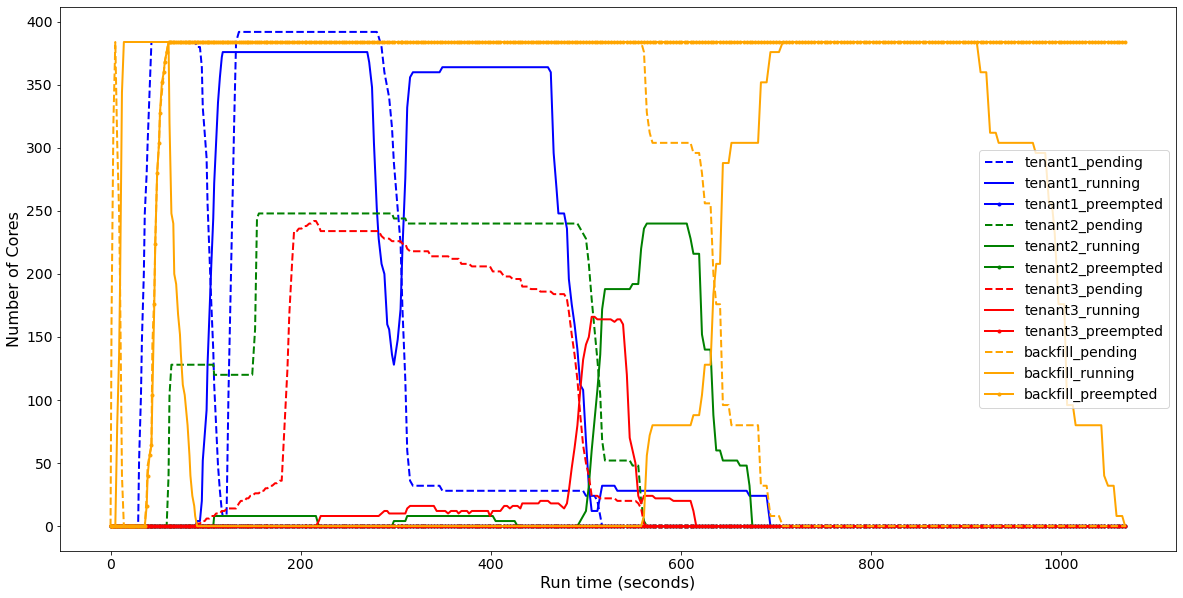

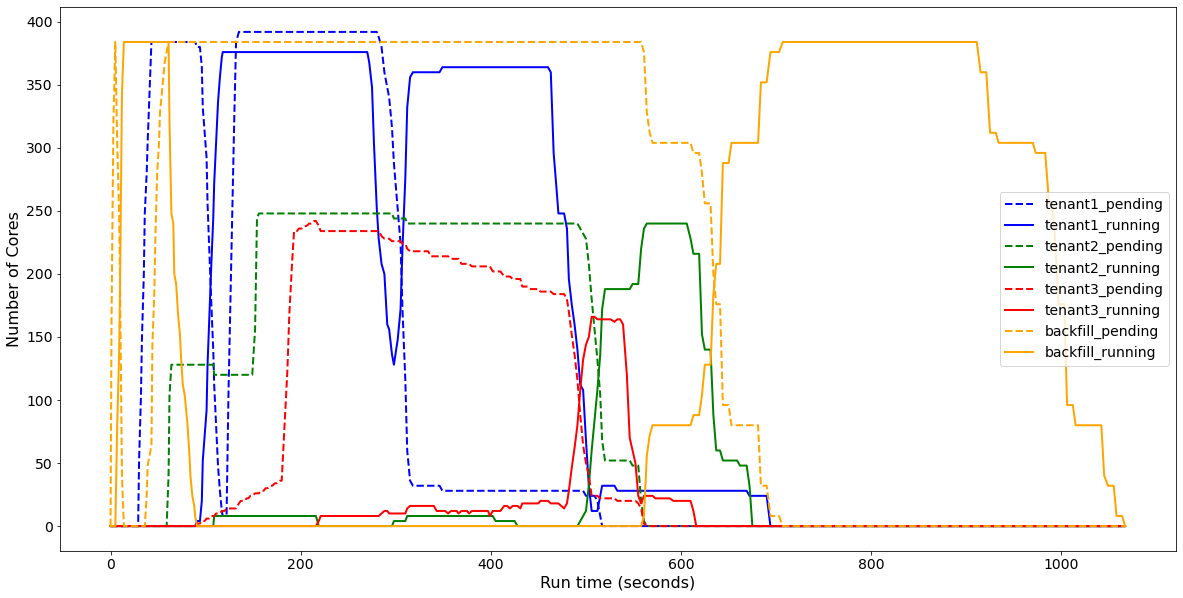

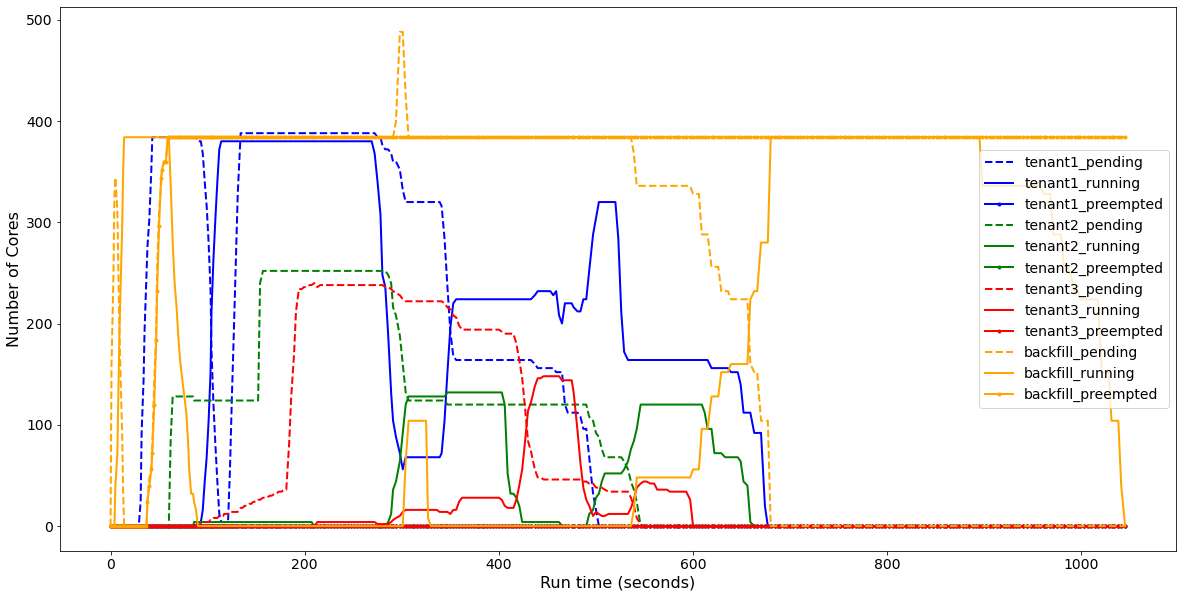

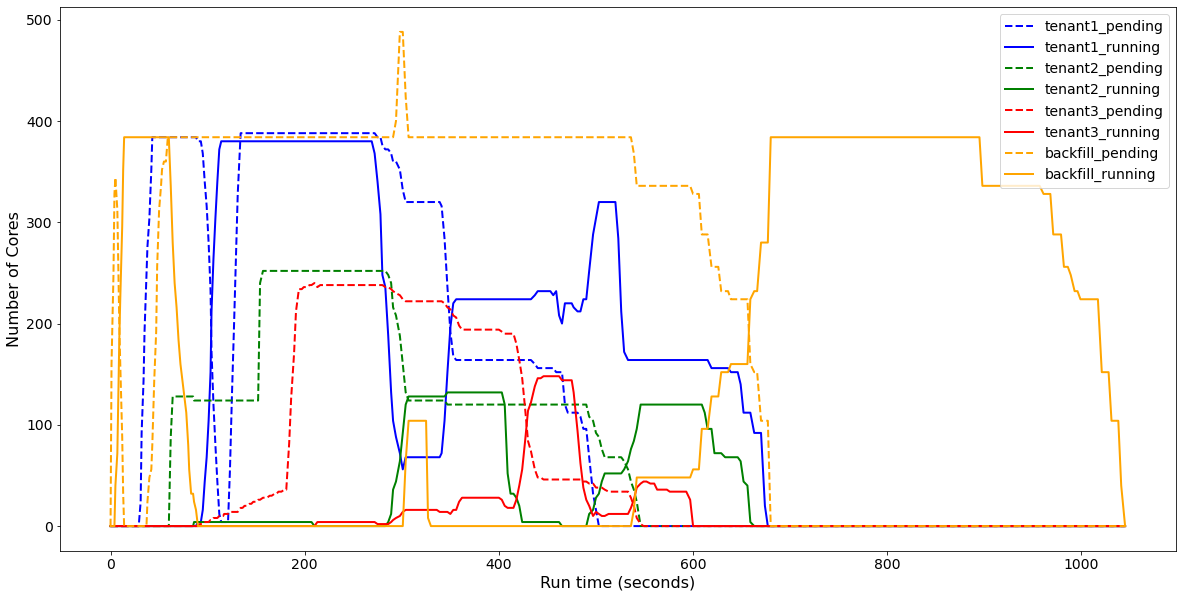

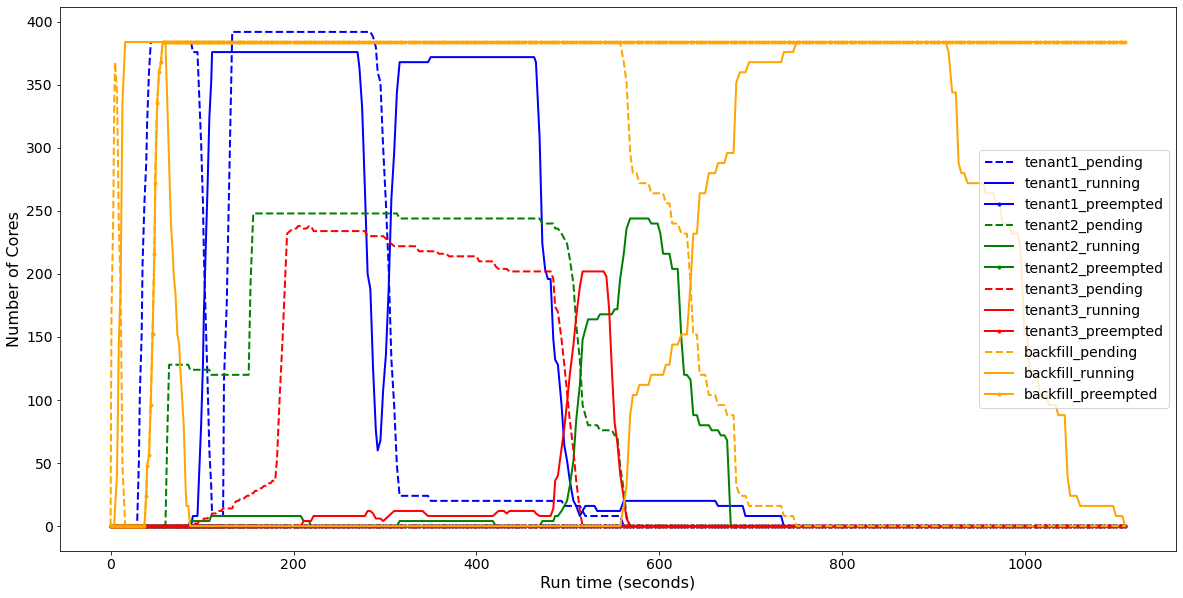

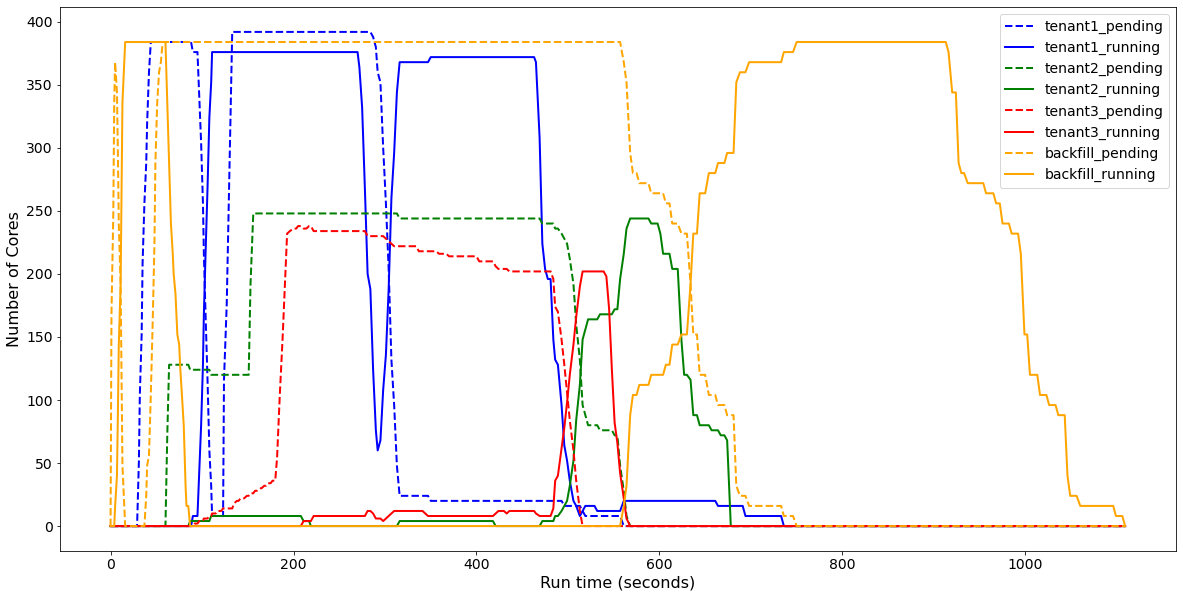

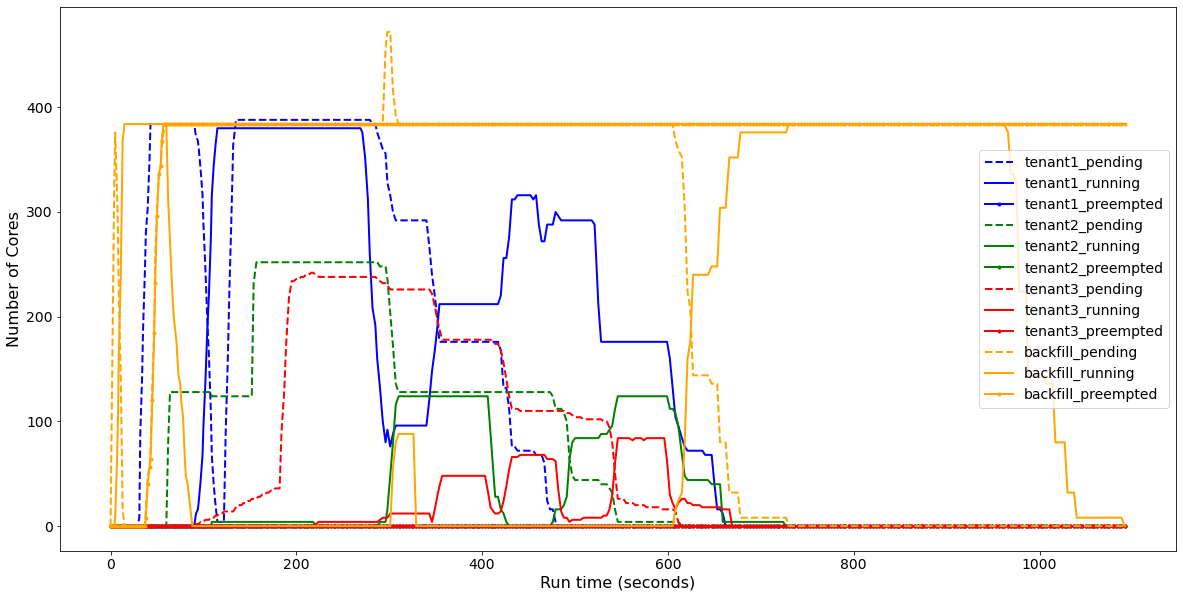

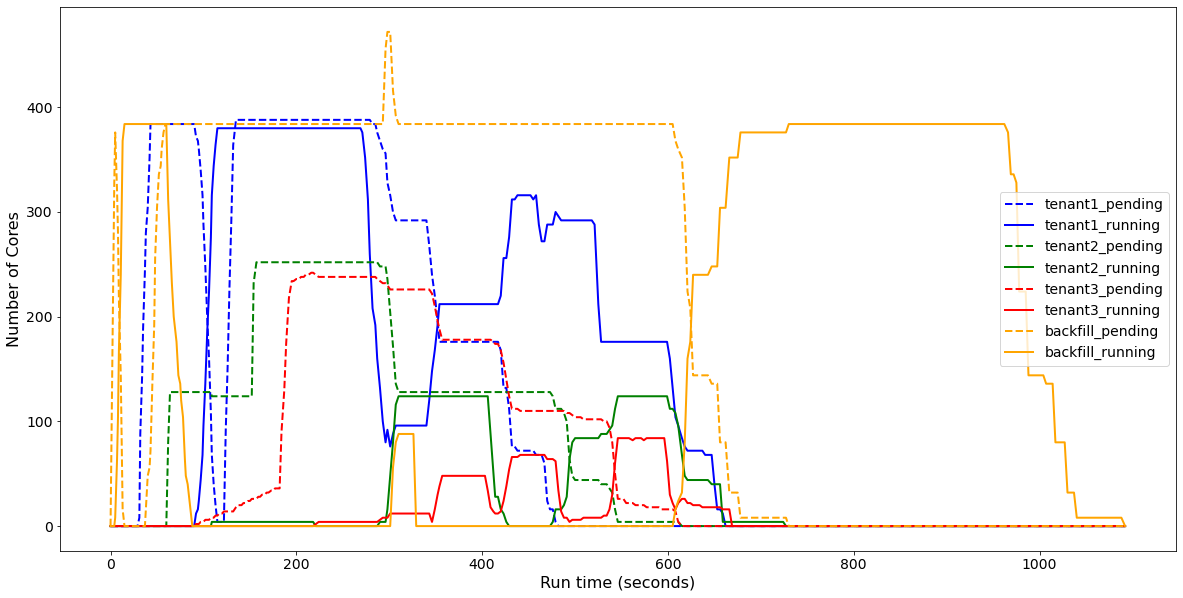

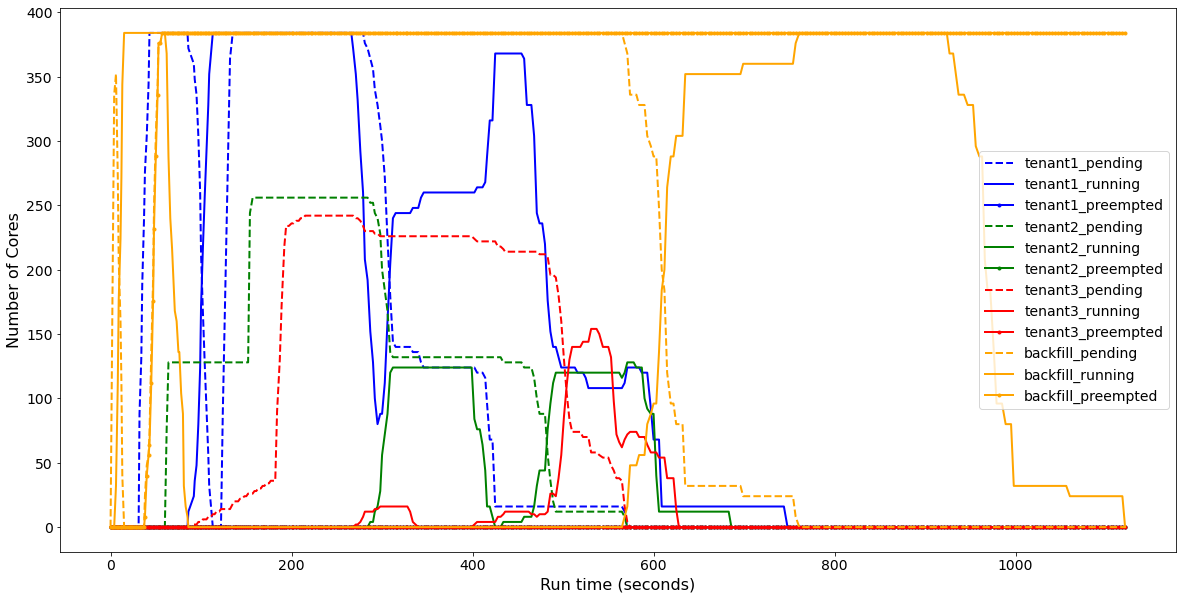

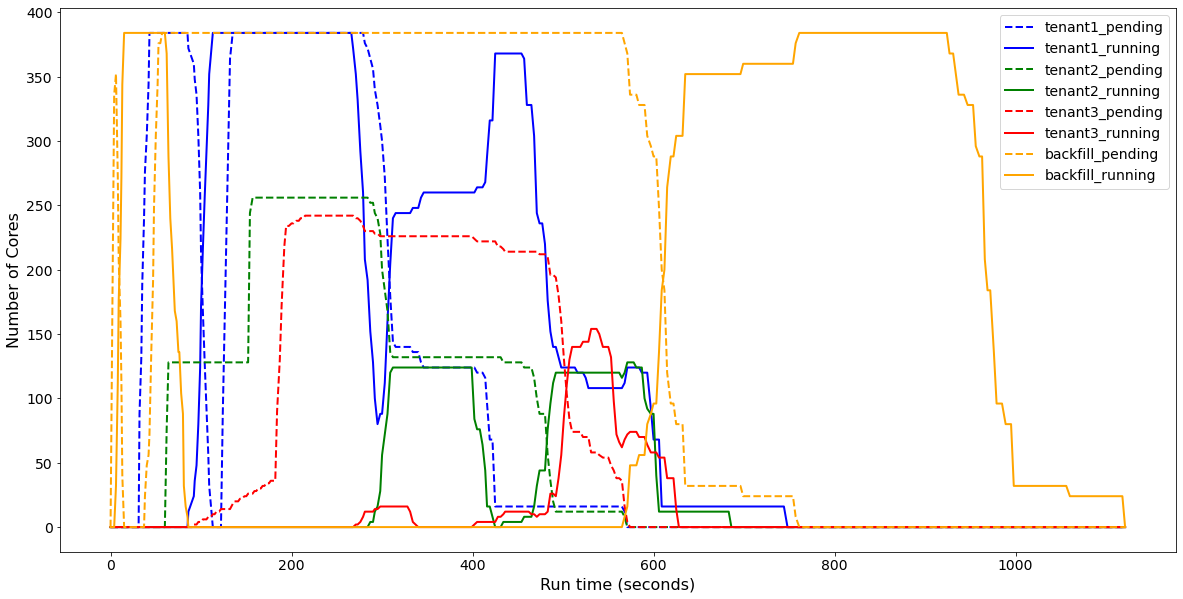

In [6]:
experiment_name = "E5"
namespaces = ["tenant1", "tenant2", "tenant3", "backfill"]
#schedulers = ["yunikorn"]
schedulers = ["default-scheduler"]
#schedulers = ["scheduler-plugins-scheduler"]
#schedulers = ["nos-scheduler"]


# [start_time, cpu_limit, mem_limit, num_jobs, sleep_time]
# cms
bursts_tenant1 = [
    [30,  "4", "8G", 96, "180"],
    [120, "4", "8G", 96, "180"]
]

# ag
bursts_tenant2 = [
    [60,  "4", "8G", 32, "120"],
    [150, "4", "8G", 32, "120"]
] 

# ds
bursts_tenant3 = [
    #[60, "2", "4G", 48, "60"],
    [180, "2", "4G", 96, "60"]

]

# backfill
bursts_tenant4 = [
    [0, "8", "16G", 48, "360"],
]

params = [
    ["tenant1",  "0", "4G", 130, "60", bursts_tenant1, 1, experiment_name],
    ["tenant2",  "0", "4G", 160, "60", bursts_tenant2, 1, experiment_name],
    ["tenant3",  "2", "4G", 25,  "60", bursts_tenant3, 5, experiment_name],
    ["backfill", "0", "4G", 180, "60", bursts_tenant4, 1, experiment_name], 
]

run_experiment(experiment_name, namespaces, params, schedulers)

## Capacity Scheduler

## YuniKorn

## Experiment 1: Single tenant - tenant1

## Experiment 1: Single tenant - tenant2

## Experiment 1: Single tenant - tenant3

## Experiment 2: Multi-tenant with resource quotas

## Experiment 4: Multi-tenant with fairshare to whole cluster

## Experiment 5: Multi-tenant and backfill with fairshare to whole cluster


### Dictionary format used to store experiment data

Assuming `namespaces = ["tenant1", "tenant2", "tenant3"]` the dictionary would be created as follows:
```
data = {
    'timestamp':[1,2,3,4,5],
    'tenant1_pending':[3,4,3,4,5],
    'tenant1_running':[5,6,5,6,5],
    'tenant1_completed':[7,6,7,8,7],
    'tenant2_pending':[1,1,1,1,1],
    'tenant2_running':[2,2,2,2,2],
    'tenant2_completed':[3,3,3,3,3],
    'tenant3_pending':[2,3,2,3,2],
    'tenant3_running':[3,4,3,4,3],
    'tenant3_completed':[5,5,5,5,5],
}
```
```
# format of parameters list of lists
# params = [
#     [namespace1, cpu_limit, mem_limit, num_jobs, sleep_time, submission_interval],
#     [namespace2, cpu_limit, mem_limit, num_jobs, sleep_time, submission_interval],
# ]
```

In [7]:
# 196, 216 (pending)
# 104, 128 (pending)
# 64, 88 (pending)
# 40, 64 (pending)
# 32, 56 (pending)
# 32, 56 (pending)
# 196, 216 (pending)
# 112, 136 (pending)
# 64, 88 (pending)
# 48, 72 (pending)
# 32, 56 (pending)
# 24, 32 (pending)
# 24, 32 (pending)

